# Ai Lab Project: Cube Color Detector

## Drive initialization step

This step is necessary to mount a Google Drive folder on the Google Colab runtime.

Instructions here: https://stackoverflow.com/a/65886348

In [14]:
DRIVE_FS_MOUNTPOINT = '/content/drive/MyDrive'
DRIVE_IN_PATH = '/computer_vision/'
ROOT_DRIVE = DRIVE_FS_MOUNTPOINT + DRIVE_IN_PATH

import os.path, os

assert os.path.isdir(DRIVE_FS_MOUNTPOINT), 'Google Drive has not been mounted from the side menu yet'
print('✔️ Google Drive mounted')

assert os.path.isdir(ROOT_DRIVE), f'Project folder not found. Please create a folder in this location on your Google Drive: {DRIVE_IN_PATH}'
print('✔️ Project folder found')

✔️ Google Drive mounted
✔️ Project folder found


In this first step our goal is to obtain the edges of the face of the cube in order to be able to isolate it and work with it.
First we get the coordinates of the points on the edges of the face.


We apply the blur to make the cells of the face more homogeneous, since we want to work later on a single pixel when inside the cell for reasons of lights and perspectives they could have different values. 
We use a Gaussian blur in order to preserve the edges.

In [4]:
def getFaceShape(img):
  #get the greyscale image 
  grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  #apply the gaussian blur to uniform the color of the pixels
  img = cv2.GaussianBlur(img,(3,3),0)

  #detect the edges of the image
  edges = cv2.Canny(img,100,200)

  #take x and y coordinates of the withe pixels
  white_pixels = np.where(edges == 255)
  return np.array(white_pixels)


Once the coordinates of the points on the edges have been taken, we only take the coordinates that interest us, i.e. those of the vertices, which will be necessary for the omography of the image.

In [ ]:
def getFaceVertices(matches):
  #find the vertices of the cube's face
  top_l_idx = np.argmin(matches[0] + matches[1])
  print(top_l_idx)
  bott_l_idx = np.argmax(matches[0] - matches[1])
  print(bott_l_idx)
  bott_r_idx = np.argmax(matches[0] + matches[1])
  print(bott_r_idx)
  top_r_idx = np.argmax(matches[1] - matches[0])
  print(top_r_idx)

  #  reverse X and Y of the point
  return np.array([
      matches[:, top_l_idx][::-1],
      matches[:,top_r_idx][::-1],
      matches[:,bott_r_idx][::-1],
      matches[:, bott_l_idx][::-1],
  ])

Homography is applied to the image so that we can only work on the pixels of the face of the cube and give the image a standard size to make the problem easier.

In [12]:
def deleteImageOutline(img, points, width):
  # Apply the trasformation
  src_points = np.array(points, dtype=np.float32)
  # Destination height is the same as width, because the image is a square (it's a cube...)
  dest_points = np.array([
      [ 0, 0 ],
      [ width, 0 ],
      [ width, width ],
      [ 0, width ],
  ], dtype=np.float32)
  match_matrix = cv2.getPerspectiveTransform(src_points, dest_points)
  return cv2.warpPerspective(img, match_matrix, (width, width))



Given the face of the cube, we take the central pixel of each cell and determine its color on the basis of previously established ranges.

In [6]:
# Ranges of the color to detect in the image
color_ranges = {
    'white':(np.array([0, 0, 200],dtype=np.uint8),np.array([120, 90, 255],dtype=np.uint8)),
    'red':(np.array([0, 200, 200],dtype=np.uint8),np.array([5, 255, 255],dtype=np.uint8)),
    'orange':(np.array([9, 130, 100],dtype=np.uint8),np.array([17, 255, 255],dtype=np.uint8)),
    'yellow':(np.array([20, 100, 100],dtype=np.uint8),np.array([25, 255, 255],dtype=np.uint8)),
    'green':(np.array([40, 50, 80],dtype=np.uint8),np.array([80, 255, 255],dtype=np.uint8)),
    'blue':(np.array([90, 100, 50],dtype=np.uint8),np.array([120, 255, 255],dtype=np.uint8))
}

def getColorsFromCubeFace(cube_face_img):
  cube_face_hsv = cv2.cvtColor(cube_face_img, cv2.COLOR_BGR2HSV)
  cube_face_step = cube_face_img.shape[0] // 6 # Divide 3x3 face in 6x6 in order to get the center

  cube_points = [
      cube_face_hsv[y, x]
      for y in range(cube_face_step, cube_face_hsv.shape[0]-1, cube_face_step*2)
      for x in range(cube_face_step, cube_face_hsv.shape[0]-1, cube_face_step*2)
  ]
  colors = np.array([
      recognizeColor(pixel)
      for pixel in cube_points
  ]).reshape(3,3)
  # use matrix representetion
  print(colors)

#recognize the color of the nine points took from the image
def recognizeColor(pixel):
  for color, (lower,upper) in color_ranges.items():
    if cv2.inRange(pixel,lower,upper).all():
      return color


##Face color detection test

[[ 33  33  33 ... 115 115 115]
 [ 40  41  42 ...  40  41  42]]
73
1075
992
72


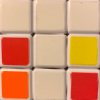

[['white' 'white' 'white']
 ['red' 'white' 'yellow']
 ['orange' 'white' 'red']]


In [16]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow 


# Load image and downscale, keeping the aspect ratio
origin = cv2.imread(ROOT_DRIVE+"rubik.jpg")
width = 100
height =int(origin.shape[0]*width/origin.shape[1])
img = cv2.resize(
    origin,
    (width,height)
)
# cv2_imshow(img)

matches = getFaceShape(img)
print(matches)
points = getFaceVertices(matches)
cube_face_img = deleteImageOutline(img, points, width)
cv2_imshow(cube_face_img)
getColorsFromCubeFace(cube_face_img)